In [1]:
import numpy as np
import cv2
from torch.utils.data import Dataset
import sys
sys.path.insert(0, "/kaggle/input/ocr-scripts-task-1")
from data import MidvPackage
import torch
from torchvision import models
from torchvision.models.segmentation import DeepLabV3_MobileNet_V3_Large_Weights
from torch.utils.data import DataLoader
from IPython.display import clear_output
from pathlib import Path
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision.transforms import functional as F
from metrics import dump_results_dict, measure_crop_accuracy
import albumentations as A


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def create_mask(quad, img_shape):
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    quad = np.array(quad, dtype=np.int32)
    cv2.fillPoly(mask, [quad], 1)
    return mask

In [3]:
class MIDVDatasetSegmentation(Dataset):
    def __init__(self, data_packs, test=False):
        self.data_packs = data_packs
        self.test = test
        self.indices = []
        self.transform = A.Compose([
            A.Rotate(limit=(20, 340), p=0.5)
        ])

        
        for pack_idx, pack in enumerate(data_packs):
            for image_idx, image in enumerate(pack):
                if test and image.is_test_split():
                    self.indices.append((pack_idx, image_idx))
                elif not test and not image.is_test_split():
                    self.indices.append((pack_idx, image_idx))

        
    def __getitem__(self, idx):
        pack_idx, image_idx = self.indices[idx]
        data_item = self.data_packs[pack_idx][image_idx]  

        img = np.array(data_item.image)
        quad = np.array(data_item.gt_data['quad'], dtype=np.float32)
        
        mask = create_mask(quad, img.shape)
        if not self.test:
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']

        return torch.tensor(img).permute(2, 0, 1).float(), torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

    def __len__(self):
        return len(self.indices)

In [4]:
DATASET_PATH = Path('/kaggle/input/midv500/midv500')
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)

In [5]:
dataset = MIDVDatasetSegmentation(data_packs)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [5]:
device = torch.device("cuda")

In [6]:
model = models.segmentation.deeplabv3_mobilenet_v3_large(DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1)
model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=1)
model.to(device);

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 90.6MB/s]


In [8]:
class Loss(torch.nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.bce = torch.nn.BCEWithLogitsLoss()
        
    def forward(self, pred, target):
        smooth = 1.
        iflat = pred.contiguous().view(-1)
        tflat = target.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        dice = 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )
        bce = self.bce(pred, target)
        return 0.4 * dice + 0.6 * bce

In [9]:
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 2 * len(dataloader))
criterion = Loss()

In [10]:
def train_model(model, dataloader, optimizer, criterion, num_epochs=1):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        for batch, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            if batch % 10 == 0:
                clear_output(wait=True)
                plt.plot(losses, label='Training Loss')
                plt.show()

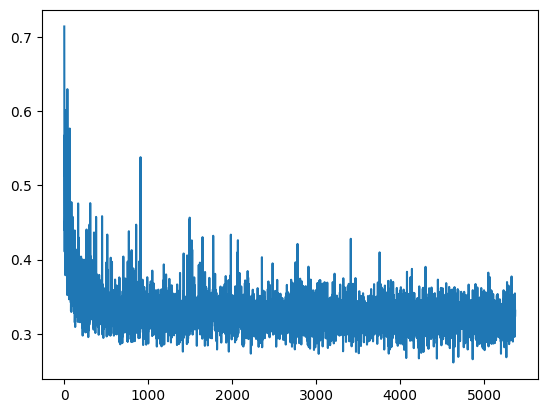

In [11]:
train_model(model, dataloader, optimizer, criterion, num_epochs=2)

In [7]:
def mask_to_quad(mask):
    binary_mask = (mask > 0).cpu().numpy().astype(np.uint8)
    contours, _ = cv2.findContours(binary_mask.squeeze(0), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        contour = max(contours, key=cv2.contourArea)
        x, y = contour[:, 0, 0], contour[:, 0, 1]

        corners_indices = np.array([np.argmin(x + y), np.argmin(-x + y), np.argmax(x + y), np.argmax(-x + y)])
        corners = np.array([x[corners_indices], y[corners_indices]]).T

        return corners.astype(float)
    return np.zeros((4, 2), dtype=float)

In [8]:
dataset = MIDVDatasetSegmentation(data_packs, test=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [9]:
def to_relative_scale(quad, h, w):
    quad = quad
    for i in range(len(quad)):
        quad[i][0] /= w
        quad[i][1] /= h 
    return quad

In [18]:
model.load_state_dict(torch.load("/kaggle/input/models/model (1).pth"))

/tmp/ipykernel_30/951222007.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/models/model (1).pth"))


<All keys matched successfully>

In [19]:
results_dict = dict()
model.eval()
with torch.no_grad():
    for dp in tqdm(data_packs):
        for i in range(len(dp)):
            if dp[i].is_test_split():
                try:
                    img = torch.FloatTensor(np.array(dp[i].image)).permute([2, 0, 1]).to(device)
                    mask = model(img.unsqueeze(0))['out']
                    corners = mask_to_quad(mask.squeeze(0))
                    results_dict[dp[i].unique_key] = to_relative_scale(corners, img.size()[1], img.size()[2])
                except Exception as exc:
                    print(exc)

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
dump_results_dict(results_dict, Path() / 'pred.json')

In [21]:
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / '/kaggle/input/gt-ocr-task1/gt.json'
)

In [22]:
acc

0.8997647058823529